# 실험 준비

모듈 임포트

In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt

결과 확인을 위한 이미지 출력 함수 정의

In [2]:
def image_show(image, width=10, height=10):
    # Ensure the image is in a compatible format for cv2.cvtColor (CV_8U or CV_32F)
    if image.dtype != np.uint8:
        image = np.clip(image, 0, 255).astype(np.uint8)  # Convert to uint8 by clipping and casting
    
    # Create a larger figure
    plt.figure(figsize=(width, height))
    
    # Convert the image from BGR to RGB for correct color display
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()

In [3]:
org_image = cv2.imread('./data/cat_128.png') #원본 이미지
org_video_path = 'data/코끼리_480_270_short.mp4'  #원본 비디오 경로

# 가장 기본적인 형태 - 아무 병렬화도 하지 않음

가장 기본적인 쌍선형 보간 up_sampling함수

In [4]:
def up_sample_frame_v0(source_image, scale_factor):
    src_h, src_w  = source_image.shape[:2]
    dest_h, dest_w = int(src_h*scale_factor), int(src_w*scale_factor)
    
    slope_h = src_h / dest_h
    intercept_h = (slope_h - 1) / 2

    slope_w = src_w / dest_w
    intercept_w = (slope_w - 1) / 2

    dest_image = np.zeros((dest_h, dest_w, 3))  # 변환된 이미지 생성
    source_image = np.pad(source_image, pad_width=((1, 1), (1, 1), (0, 0)), mode='edge')  # 패딩 추가

    for y_dest in range(dest_h):
        for x_dest in range(dest_w):
            x_src = slope_w * x_dest + intercept_w
            y_src = slope_h * y_dest + intercept_h

            x0, y0 = int(x_src), int(y_src)
            x1, y1 = x0 + 1, y0 + 1

            wx = x_src - x0
            wy = y_src - y0

            v1 = source_image[y0, x0]
            v2 = source_image[y0, x1]
            v3 = source_image[y1, x0]
            v4 = source_image[y1, x1]

            dest_image[y_dest, x_dest] = (
                (1 - wx) * (1 - wy) * v1 +
                wx * (1 - wy) * v2 +
                (1 - wx) * wy * v3 +
                wx * wy * v4
            )

    return dest_image.astype(np.uint8)
    

openCV 쌍선형 보간 upsampling 함수 (아래 up_sampler로 이용할 수 있는 형태로 만들기 위해서 정의)

In [5]:
def up_sample_frame_openCV(source_image, scale_factor):
    return cv2.resize(source_image, (int(source_image.shape[1]*scale_factor), int(source_image.shape[0]*scale_factor)), interpolation=cv2.INTER_LINEAR)

입력 비디오의 각 프레임에 대해 제공된 transform_frame_fn을 적용한 후 새로운 비디오를 생성하여 저장하는 함수

In [6]:
def up_sample_video(input_video_path, output_video_path, up_sampler, scale_factor):
    """
    입력 비디오의 각 프레임에 대해 제공된 transform_frame_fn을 적용한 후 새로운 비디오를 생성합니다.
    
    :param input_video_path: 입력 비디오 파일 경로
    :param output_video_path: 출력 비디오 파일 경로
    :param transform_frame_fn: 프레임을 처리할 함수
    """
    # 비디오 캡처 객체 생성
    cap = cv2.VideoCapture(input_video_path)
    
    #원본의 fps유지
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # 비디오 출력 객체를 위한 설정
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # 출력 비디오 코덱 (예: XVID)
    
    # 비디오 캡처에서 첫 번째 프레임을 읽어 새 크기 결정 (화질 개선 함수로 크기가 변경될 수 있음)
    ret, first_frame = cap.read()
    if not ret:
        print("비디오 읽기 실패")
        return
    
    #새로운 프레임 크기 계산
    new_height, new_width = int(first_frame.shape[0] * scale_factor), int(first_frame.shape[1] * scale_factor)
    # 비디오 출력 객체 생성 (변경된 크기 사용)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (new_width, new_height))

    # 비디오 프레임 처리
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 첫 번째 프레임으로 다시 이동
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # 각 프레임에 화질 개선 함수 적용
        enhanced_frame = up_sampler(frame, scale_factor)
        
        # 개선된 프레임을 출력 비디오에 추가
        out.write(enhanced_frame)
        
    # 리소스 해제
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"비디오 처리 완료: {output_video_path}")

이미지 처리 결과 비교

orginal image


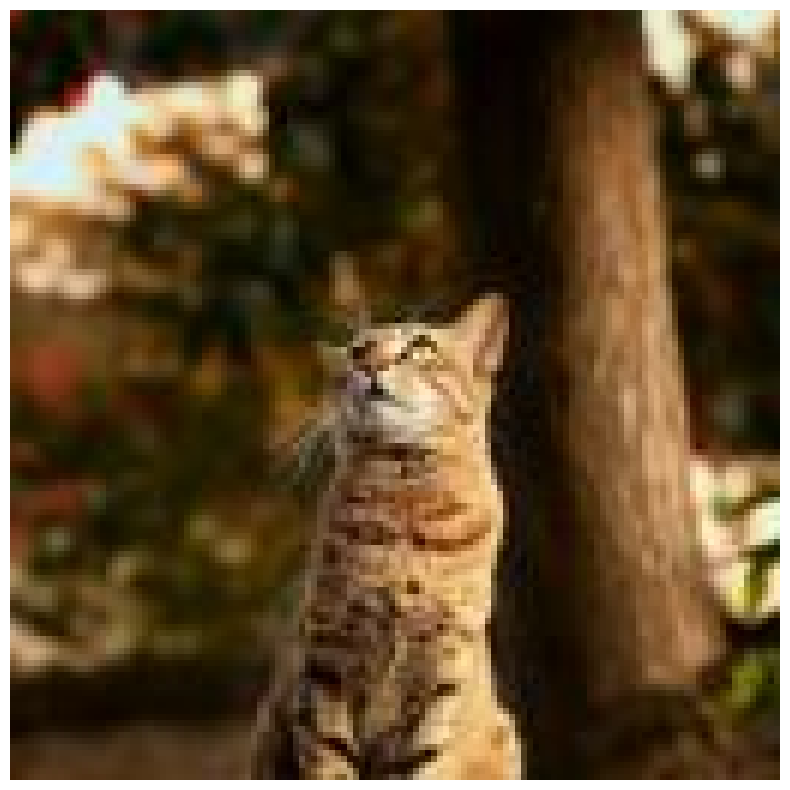

up sampled image - v0
Image shape: (512, 512, 3)  Execution time: 2.22948861 seconds


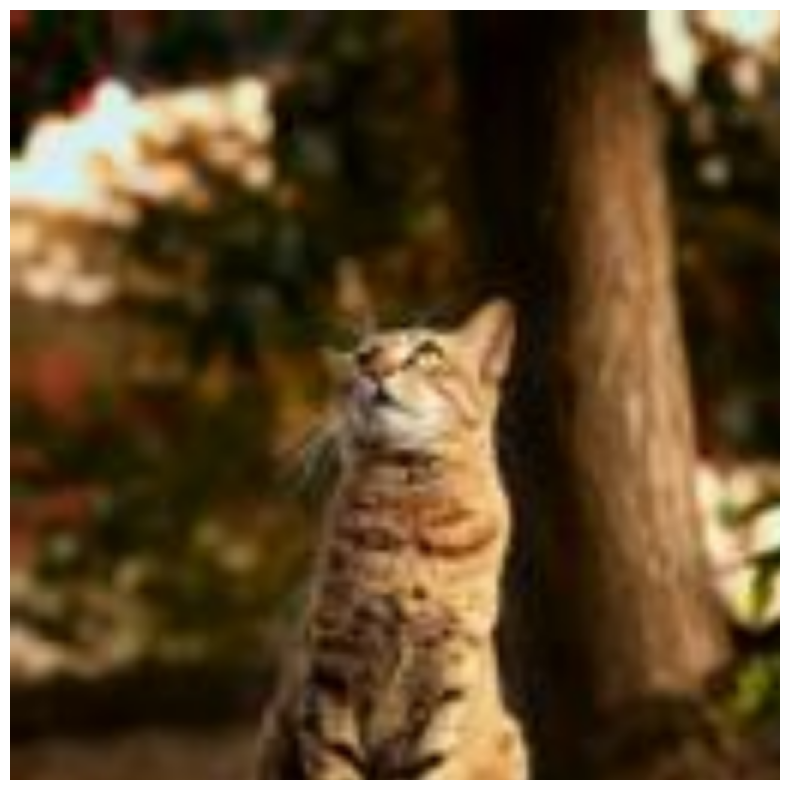

up sampled image - openCV
Image shape: (512, 512, 3)  Execution time: 0.00101209 seconds


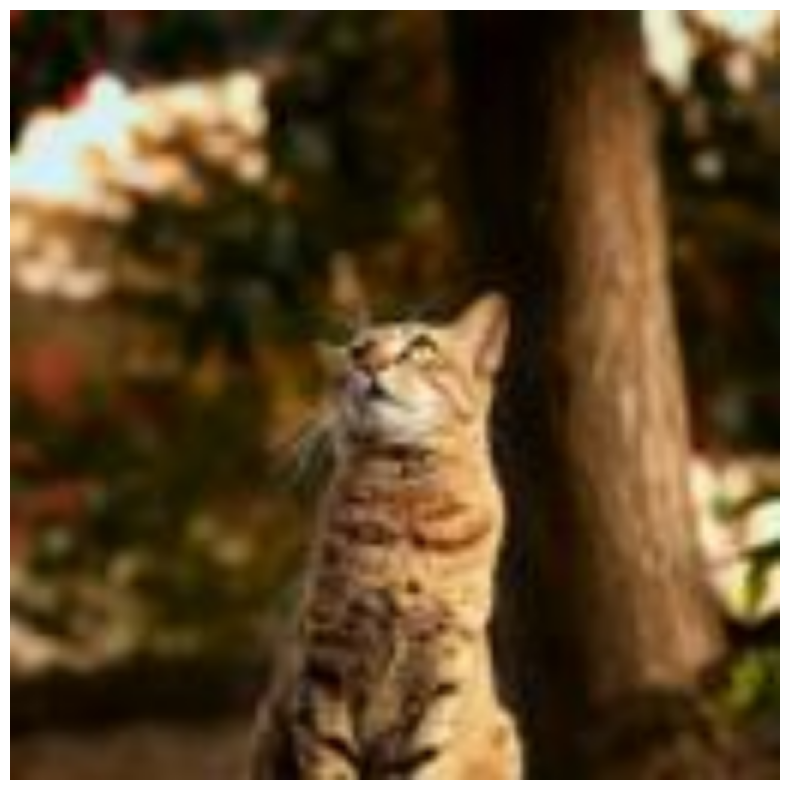

In [7]:
scale_factor = 4 #4배 늘림

#원본 이미지 출력
print("orginal image")
image_show(org_image)

#v0 함수로 up sampling
start_time = time.time()
up_sampled_image = up_sample_frame_v0(org_image, scale_factor) 
end_time = time.time()

#v0 결과 출력
print("up sampled image - v0")
print(f"Image shape: {up_sampled_image.shape}  Execution time: {(end_time - start_time):.8f} seconds")
image_show(up_sampled_image)

#openCV 함수로 up sampling
start_time = time.time()
up_sampled_image = up_sample_frame_openCV(org_image, scale_factor)
end_time = time.time()

#openCV 결과 출력
print("up sampled image - openCV")
print(f"Image shape: {up_sampled_image.shape}  Execution time: {(end_time - start_time):.8f} seconds")
image_show(up_sampled_image)


동영상 처리 결과 비교

In [8]:
#v0
start_time = time.time()
up_sample_video(org_video_path, 'data/코끼리_up_sampled_v0.mp4', up_sample_frame_v0, 2)
end_time = time.time()
print(f"v0 Execution time: {(end_time - start_time):.6f} seconds")

#openCV
start_time = time.time()
up_sample_video(org_video_path, 'data/코끼리_up_sampled_openCV.mp4', up_sample_frame_openCV, 2)
end_time = time.time()
print(f"openCV Execution time: {(end_time - start_time):.6f} seconds")

비디오 처리 완료: data/코끼리_up_sampled_v0.mp4
v0 Execution time: 161.438710 seconds
비디오 처리 완료: data/코끼리_up_sampled_openCV.mp4
openCV Execution time: 0.204574 seconds


시간이 매우 많이 차이난다. 아무 병렬화가 되지 않았을 때는 매우 느리게 작동하여 실제로 사용할 수 없을 수준이다.